In [21]:
import pandas as pd
from pysam import VariantFile, VariantRecord
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from typing import List, Dict, Tuple

In [29]:
## INPUTS

# Path to the population VCF file which is the output of Sniffles merge
VCF = '/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/snfs/wagyu.cohort.vcf'


# Minimum quality of the SV to be considered in this analysis.
SV_QUAL = 20

class Args:
    def __init__(self):
        self.vcf = VCF
        self.sv_qual = SV_QUAL
args = Args()

def extract_sv_info(record: VariantRecord, sample: str, caller:str, found_in_sample:str) -> Tuple[str, int, str, str, str, str, int]:
    """
    Extract relevant information from the VCF record for a given sample.
    """
    
    # Give the SV an ID based on CHROM:POS:ENDPOS:SVTYPE
    sv_id = f'{record.chrom}:{record.pos}:{record.stop}:{record.info["SVTYPE"]}'
        
    # Get the SV length, SVTYPE, chromosome, and given ID
    # The given ID is what the SV caller gives it.
    sv_len = np.abs(record.info['SVLEN'])
    sv_type = record.info['SVTYPE']
    sv_chrom = record.chrom
    given_id = record.id

    caller = caller
    if record.samples[sample]['GT'] == (0,1):
        n_alleles = 1
    elif record.samples[sample]['GT'] == (1,1):
        n_alleles = 2
    else:
        n_alleles = 0

    return tuple([sv_id, sv_len, sv_type, sv_chrom, given_id, caller, n_alleles, found_in_sample])

In [35]:
# Create a dictionary to store the SV results
samples = {'sample':[],
           'caller':[],
           'sv_id':[],
           'given_id':[],
           'sv_type':[],
           'chrom':[],
           'sv_length':[],
           'n_alleles':[],
           'in_sample':[]
           }

vcf: VariantFile = VariantFile(args.vcf)

samples_list: List = list(vcf.header.samples)

for record in tqdm(vcf.fetch()):
    
    # Skip the record if the genotype quality is below the threshold (20)
    if record.qual < args.sv_qual:
        continue

    if record.info['SVTYPE'] == 'BND':
        continue  

    if np.abs(record.info['SVLEN']) > 3000000:
        continue

      

    #print(record)
    support_vec = record.info['SUPP_VEC']
    support = record.info['SUPPORT']

    # If there is either two samples with the SV or one sample with 2 reads supporting the SV
    # then we keep it.
    if support_vec.count('1') >= 2 or support >= 2:
        # Get the SV type
        sv_type = record.info['SVTYPE']
        
        # Get the SV length
        sv_length = record.info['SVLEN']
        
        # Get the number of alleles
        n_alleles = len(record.alleles)
        
        # Get the sample names
        for i, sample in enumerate(samples_list):
            
            if support_vec[i] == '0':
                found_in_sample = False
            elif support_vec[i] == '1':
                found_in_sample = True

            # Extract the relevant information from the VCF record
            sv_id, sv_len, sv_type, sv_chrom, given_id, caller, n_alleles, in_sample = extract_sv_info(record=record, sample=sample, caller='sniffles', found_in_sample=str(found_in_sample))
            
            # Append the information to the dictionary
            samples['sample'].append(sample)
            samples['caller'].append(caller)
            samples['sv_id'].append(sv_id)
            samples['given_id'].append(given_id)
            samples['sv_type'].append(sv_type)
            samples['chrom'].append(sv_chrom)
            samples['sv_length'].append(sv_len)
            samples['n_alleles'].append(n_alleles)
            samples['in_sample'].append(in_sample)


sv_df = pd.DataFrame.from_dict(samples)

71699it [00:08, 8745.58it/s]


In [ ]:
# # Create a dictionary to store the SV results
# samples = {'sample':[],
#            'caller':[],
#            'sv_id':[],
#            'given_id':[],
#            'sv_type':[],
#            'chrom':[],
#            'sv_length':[],
#            'n_alleles':[],
#            }

# # Loop through each VCF file
# for vcf in vcfs:

#     # Get the sample name from the VCF file name
#     sample_name = os.path.basename(vcf).split('.')[0]
    
#     # create a pysam.VariantFile object for the VCF file
#     vcf = VariantFile(vcf)

#     # Loop through each record in the VCF file
#     for record in tqdm(vcf.fetch()):
#         # print(record)


#         # If the number of reads supporting the SV is less than the minimum, skip
#         if len(record.info['RNAMES']) < args.sv_cov:
#             # if the SV is not supported by the minimum number of reads, skip
#             continue

#         # If the SV type is not one of DEL, DUP, INV, or INS, skip as these are
#         # somewhat unreliable at the moment.
#         if record.info['SVTYPE'] not in ['DEL', 'DUP', 'INV', 'INS']:
#             # if the SV is not one of the four types, skip
#             continue

#         # If the GQ score for the SV is less than the minimum, skip
#         if record.qual < args.sv_qual:
#             # if the SV is not supported by the minimum quality, skip
#             continue
        
        
#         # Give the SV an ID based on CHROM:POS:ENDPOS:SVTYPE
#         sv_id = f'{record.chrom}:{record.pos}:{record.stop}:{record.info["SVTYPE"]}'
        
#         # Get the SV length, SVTYPE, chromosome, and given ID
#         # The given ID is what the SV caller gives it.
#         sv_len = record.info['SVLEN']
#         sv_type = record.info['SVTYPE']
#         sv_chrom = record.chrom
#         given_id = record.id

#         # If the SV length is greater than 3Mb, skip
#         # This was based on Tuan's 2025 AAABG conference article
#         if np.abs(sv_len) > 3000000:
#             continue

#         # We use a loop here, but there should only be one sample in the VCF file
#         # This is just the easiest way to get the correct sample name to access
#         # the sample data in the VCF file. Some SV callers will just give
#         # SAMPLE as the sample name which is different to what's in the file
#         # name above.
#         for sample in record.samples:
#             caller = 'sniffles2'

#             # Heterozygous or homozygous alt mean there is an SV present
#             if record.samples[sample]['GT'] in [(0,1), (1,1)]:
#                 # Update the samples results dictionary.
#                 samples['sample'].append(sample_name)
#                 samples['caller'].append(caller)
#                 samples['sv_id'].append(sv_id)
#                 samples['sv_type'].append(sv_type)
#                 samples['chrom'].append(sv_chrom)
#                 samples['sv_length'].append(np.abs(sv_len))
#                 samples['given_id'].append(given_id)

#                 # Get the number of alleles for the SV. E.g. if heterozygous,
#                 # n_alleles = 1
#                 if record.samples[sample]['GT'] == (0,1):
#                     n_alleles = 1
#                 elif record.samples[sample]['GT'] == (1,1):
#                     n_alleles = 2
#                 samples['n_alleles'].append(n_alleles)

#             # N 
#             elif record.samples[sample]['GT'] in [(0,0), (None,None)]:
#                 samples['sample'].append(sample_name)
#                 samples['caller'].append(caller)
#                 samples['sv_id'].append(sv_id)
#                 samples['sv_type'].append(sv_type)
#                 samples['chrom'].append(sv_chrom)
#                 samples['sv_length'].append(np.abs(sv_len))
#                 samples['given_id'].append(given_id)
#                 samples['n_alleles'].append(0)
#             else:
#                 print(record)
#                 raise ValueError('Unexpected GT')
    

[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/sample14/sample14.sniffles.vcf.gz'
26650it [00:00, 40515.44it/s]
[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/sample13/sample13.sniffles.vcf.gz'
25799it [00:00, 44633.40it/s]
[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/sample12/sample12.sniffles.vcf.gz'
25616it [00:00, 46349.30it/s]
[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/sample15/sample15.sniffles.vcf.gz'
24721it [00:00, 42529.81it/s]
[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Projects/tuwa

In [38]:
# sv_df = pd.DataFrame.from_dict(samples)
# Make a categorical variable for the SV length
sv_df['cat_SV_length'] = pd.cut(sv_df['sv_length'], bins=[0, 1000, 10000, 99999999999999999],
                            labels=['<1kb', '1-10kb', '>10kb'])
sv_df = sv_df[sv_df['sv_length'] < 3000000]
sv_df

clean_sv_df = sv_df[sv_df['in_sample'] == 'True'].copy()
clean_sv_df

,sample,caller,sv_id,given_id,sv_type,chrom,sv_length,n_alleles,in_sample,cat_SV_length
16,sample19,sniffles,1:496723:498122:DEL,Sniffles2.DEL.0M2,DEL,1,1400,2,True,1-10kb
31,sample02,sniffles,1:496907:501103:DEL,Sniffles2.DEL.1M2,DEL,1,4197,2,True,1-10kb
51,sample02,sniffles,1:516292:517689:DEL,Sniffles2.DEL.2M2,DEL,1,1398,2,True,1-10kb
63,sample10,sniffles,1:594394:595794:DEL,Sniffles2.DEL.3M2,DEL,1,1401,1,True,1-10kb
83,sample10,sniffles,1:608977:611777:DEL,Sniffles2.DEL.0M3,DEL,1,2801,2,True,1-10kb
...,...,...,...,...,...,...,...,...,...,...
1423390,sample16,sniffles,Y:59470958:59471002:DEL,Sniffles2.DEL.8M55B9,DEL,Y,45,1,True,<1kb
1423394,sample15,sniffles,Y:59470958:59471002:DEL,Sniffles2.DEL.8M55B9,DEL,Y,45,2,True,<1kb
1423399,sample20,sniffles,Y:59470958:59471002:DEL,Sniffles2.DEL.8M55B9,DEL,Y,45,0,True,<1kb
1423406,sample13,sniffles,Y:59471156:59471156:INS,Sniffles2.INS.7M55B9,INS,Y,90,1,True,<1kb


In [47]:
clean_sv_df.groupby(['sample','sv_type']).agg({'sv_type':'value_counts'}).reset_index(level=0)

,sample,sv_type
sv_type,,
DEL,sample01,10016
DUP,sample01,15
INS,sample01,8472
INV,sample01,52
DEL,sample02,8727
...,...,...
INV,sample19,54
DEL,sample20,10455
DUP,sample20,15


In [49]:
## Bubble plot
bubble_plot_df = clean_sv_df.groupby(['sv_id']).agg({'n_alleles':'sum',
                              'cat_SV_length':'first',
                              'sample':'nunique',
                              'sv_type':'first'}).reset_index()

# Only look at SVs that are present in at least 16 (80%) of samples
bubble_plot_df = bubble_plot_df[bubble_plot_df['sample'] >= 2]
bubble_plot_df = bubble_plot_df[~bubble_plot_df['sv_id'].str.contains('mat')].reset_index(drop=True)
bubble_plot_df

,sv_id,n_alleles,cat_SV_length,sample,sv_type
0,10:100229212:100235004:DEL,17,1-10kb,12,DEL
1,10:100294950:100294950:INS,4,<1kb,4,INS
2,10:100295569:100295971:DEL,13,<1kb,11,DEL
3,10:100449718:100449769:DEL,26,<1kb,16,DEL
4,10:100472891:100472953:DEL,20,<1kb,14,DEL
...,...,...,...,...,...
47447,Y:6074157:6074612:DEL,3,<1kb,2,DEL
47448,Y:6075620:6075620:INS,5,<1kb,3,INS
47449,Y:6081224:6081224:INS,3,<1kb,2,INS
47450,Y:920087:920087:INS,4,<1kb,2,INS


In [50]:

bubble_plot_df['allele_frequency'] = bubble_plot_df['n_alleles'] / 40
bubble_plot_df['allele_freq_bins'] = pd.cut(bubble_plot_df['allele_frequency'], bins=[0,0.15, 0.5, 1],
                                            labels=['<0.15', '0.15-0.5', '>0.5'])

bubble_plot_df

,sv_id,n_alleles,cat_SV_length,sample,sv_type,allele_frequency,allele_freq_bins
0,10:100229212:100235004:DEL,17,1-10kb,12,DEL,0.425,0.15-0.5
1,10:100294950:100294950:INS,4,<1kb,4,INS,0.100,<0.15
2,10:100295569:100295971:DEL,13,<1kb,11,DEL,0.325,0.15-0.5
3,10:100449718:100449769:DEL,26,<1kb,16,DEL,0.650,>0.5
4,10:100472891:100472953:DEL,20,<1kb,14,DEL,0.500,0.15-0.5
...,...,...,...,...,...,...,...
47447,Y:6074157:6074612:DEL,3,<1kb,2,DEL,0.075,<0.15
47448,Y:6075620:6075620:INS,5,<1kb,3,INS,0.125,<0.15
47449,Y:6081224:6081224:INS,3,<1kb,2,INS,0.075,<0.15
47450,Y:920087:920087:INS,4,<1kb,2,INS,0.100,<0.15


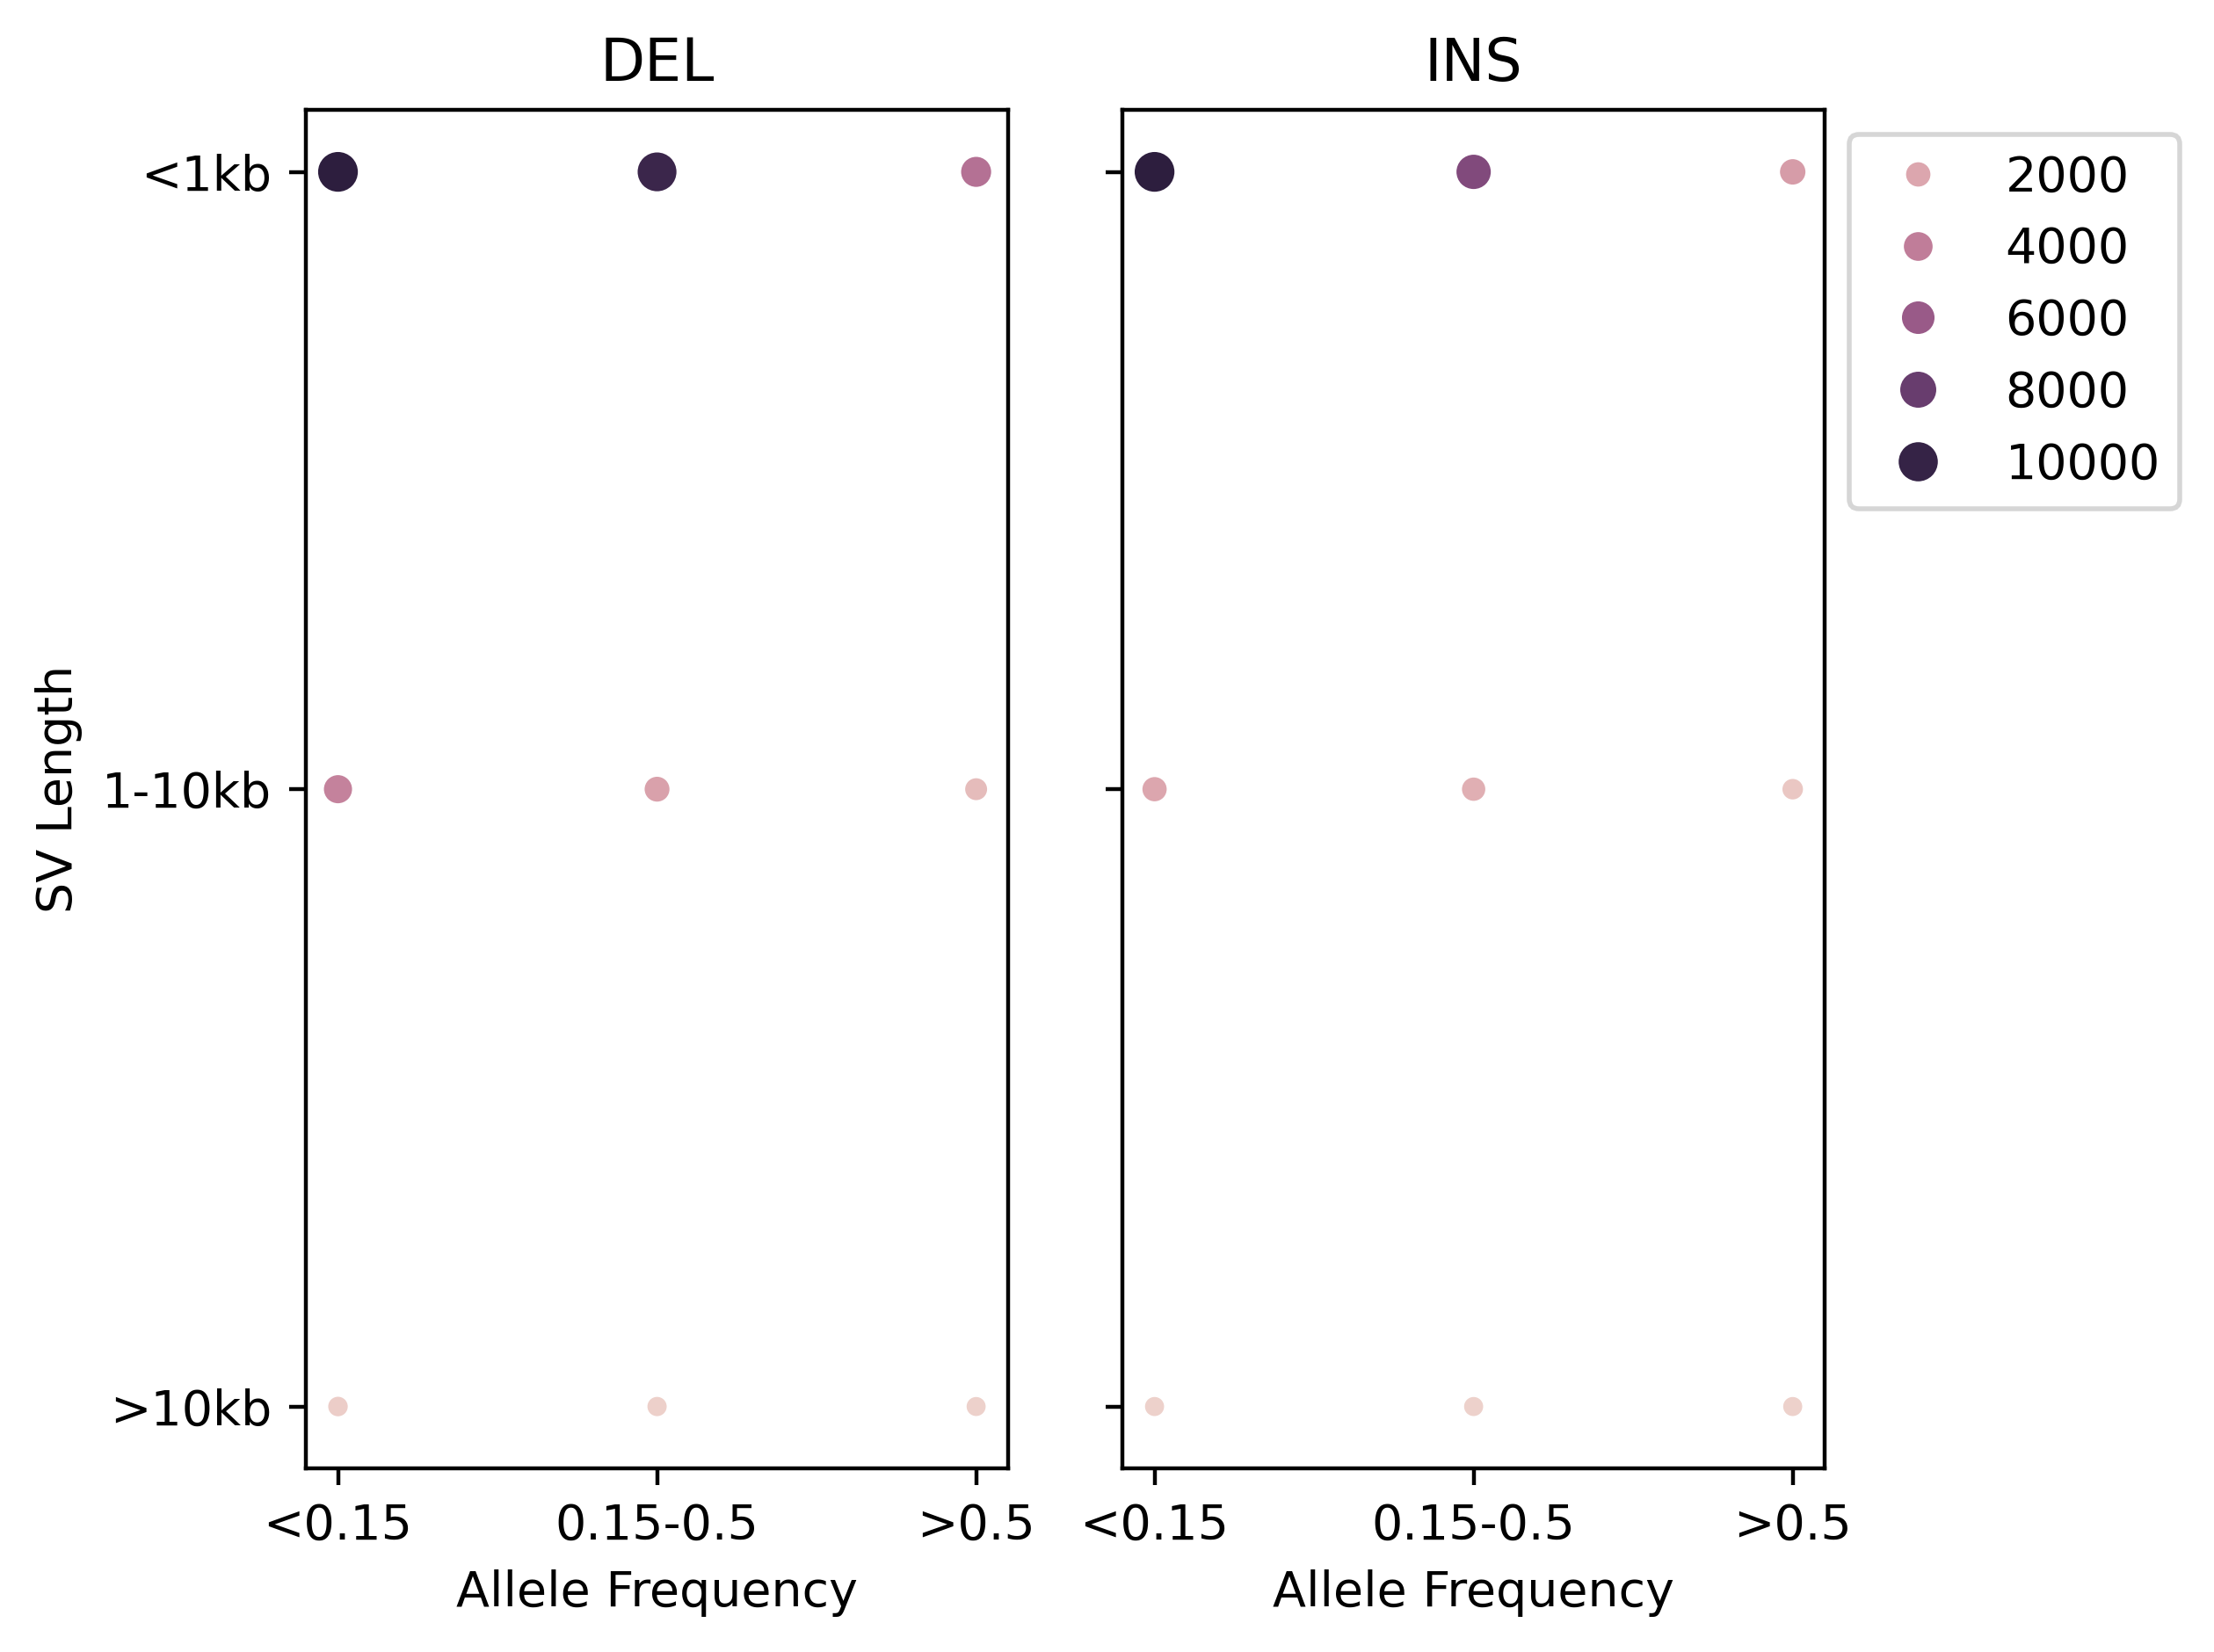

In [54]:
plot_dict = {'Allele Frequency':[],
             'SV Length':[],
             'Count':[],
             'sv_type':[]}
for allele_freq in bubble_plot_df['allele_freq_bins'].unique():
    for sv_len in bubble_plot_df['cat_SV_length'].unique():
        ins_count = bubble_plot_df[(bubble_plot_df['allele_freq_bins'] == allele_freq) & (bubble_plot_df['cat_SV_length'] == sv_len) & (bubble_plot_df['sv_type'] == 'INS')].shape[0]
        plot_dict['Allele Frequency'].append(allele_freq)
        plot_dict['SV Length'].append(sv_len)
        plot_dict['Count'].append(ins_count)
        plot_dict['sv_type'].append('INS')

        del_count = bubble_plot_df[(bubble_plot_df['allele_freq_bins'] == allele_freq) & (bubble_plot_df['cat_SV_length'] == sv_len) & (bubble_plot_df['sv_type'] == 'DEL')].shape[0]
        plot_dict['Allele Frequency'].append(allele_freq)
        plot_dict['SV Length'].append(sv_len)
        plot_dict['Count'].append(del_count)
        plot_dict['sv_type'].append('DEL')

plot_df = pd.DataFrame.from_dict(plot_dict)
plot_df = plot_df[plot_df['Count'] > 0]
plot_df = plot_df.sort_values(by=['SV Length'], ascending=[False])

allele_freq_order = ['<0.15', '0.15-0.5', '>0.5']
sv_len_order = ['<1kb', '1-10kb', '>10kb']

plot_df['Allele Frequency'] = pd.Categorical(plot_df['Allele Frequency'], categories=allele_freq_order, ordered=True)
plot_df['SV Length'] = pd.Categorical(plot_df['SV Length'], categories=sv_len_order, ordered=True)



# sns.catplot(data=plot_df,
#             x='Allele Frequency',
#             y='SV Length',
#             col='sv_type',
#             size='Count',
#             kind='strip')
fig, ax = plt.subplots(dpi=400,
             nrows=1, ncols=2,
             sharey=True)

sns.scatterplot(data=plot_df[plot_df['sv_type'] == 'DEL'],
                x='Allele Frequency',
                y='SV Length',
                size='Count',
                hue='Count',
                ax=ax[0])
ax[0].set_title('DEL')
ax[0].set_xlabel('Allele Frequency')
ax[0].set_ylabel('SV Length')

sns.scatterplot(data=plot_df[plot_df['sv_type'] == 'INS'],
                x='Allele Frequency',
                y='SV Length',
                size='Count',
                hue='Count',
                ax=ax[1])
ax[1].set_title('INS')
ax[1].set_xlabel('Allele Frequency')
ax[1].set_ylabel('SV Length')
ax[0].legend().remove()

# Move the legend to an empty part of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [57]:
svs_to_keep = clean_sv_df.groupby(['sv_id']).agg('count')
svs_to_keep = svs_to_keep[svs_to_keep['sample'] >= 2].index.tolist()

len(svs_to_keep)


47754

In [58]:
# sv_df
x = clean_sv_df[clean_sv_df['sv_id'].isin(svs_to_keep)]
x = clean_sv_df.groupby(['sample','sv_type']).agg({'sv_length':'sum'}).reset_index()
# x = x.sort_values(by=['sample', 'sv_length'], ascending=False)
x['sv_type'].unique()

array(['DEL', 'DUP', 'INS', 'INV'], dtype=object)

In [59]:
y = x[x['sv_type'].isin(['DEL','INS',
                         'DUP', 'INV'])]
plot_dict = {}
all_plot_dict = {}

for sample in y['sample'].unique():
    ins_len = y[(y['sample'] == sample) & (y['sv_type'] == 'INS')]['sv_length'].sum()
    del_len = y[(y['sample'] == sample) & (y['sv_type'] == 'DEL')]['sv_length'].sum()
    dup_len = y[(y['sample'] == sample) & (y['sv_type'] == 'DUP')]['sv_length'].sum()
    inv_len = y[(y['sample'] == sample) & (y['sv_type'] == 'INV')]['sv_length'].sum()
    all_len = ins_len + del_len + dup_len + inv_len
    plot_dict[sample] = {'INS':ins_len, 'DEL':del_len,
                         'DUP':dup_len, 'INV':inv_len}
    all_plot_dict[sample] = all_len
plot_df = pd.DataFrame.from_dict(plot_dict).T
plot_df = plot_df.reset_index()
plot_df.columns = ['sample','INS','DEL', 'DUP', 'INV',]
plot_df = plot_df.melt(id_vars='sample').rename(columns={'variable':'SV_type','value':'Length'})
all_plot_df = pd.DataFrame.from_dict(all_plot_dict, orient='index').reset_index()
all_plot_df.columns = ['sample','Length']
plot_df

,sample,SV_type,Length
0,sample01,INS,4943530
1,sample02,INS,4769068
2,sample03,INS,4318132
3,sample04,INS,5890492
4,sample05,INS,5757829
...,...,...,...
75,sample16,INV,1651011
76,sample17,INV,1824601
77,sample18,INV,1616145
78,sample19,INV,1723154


Text(0.5, 1.0, 'Length of INV SVs')

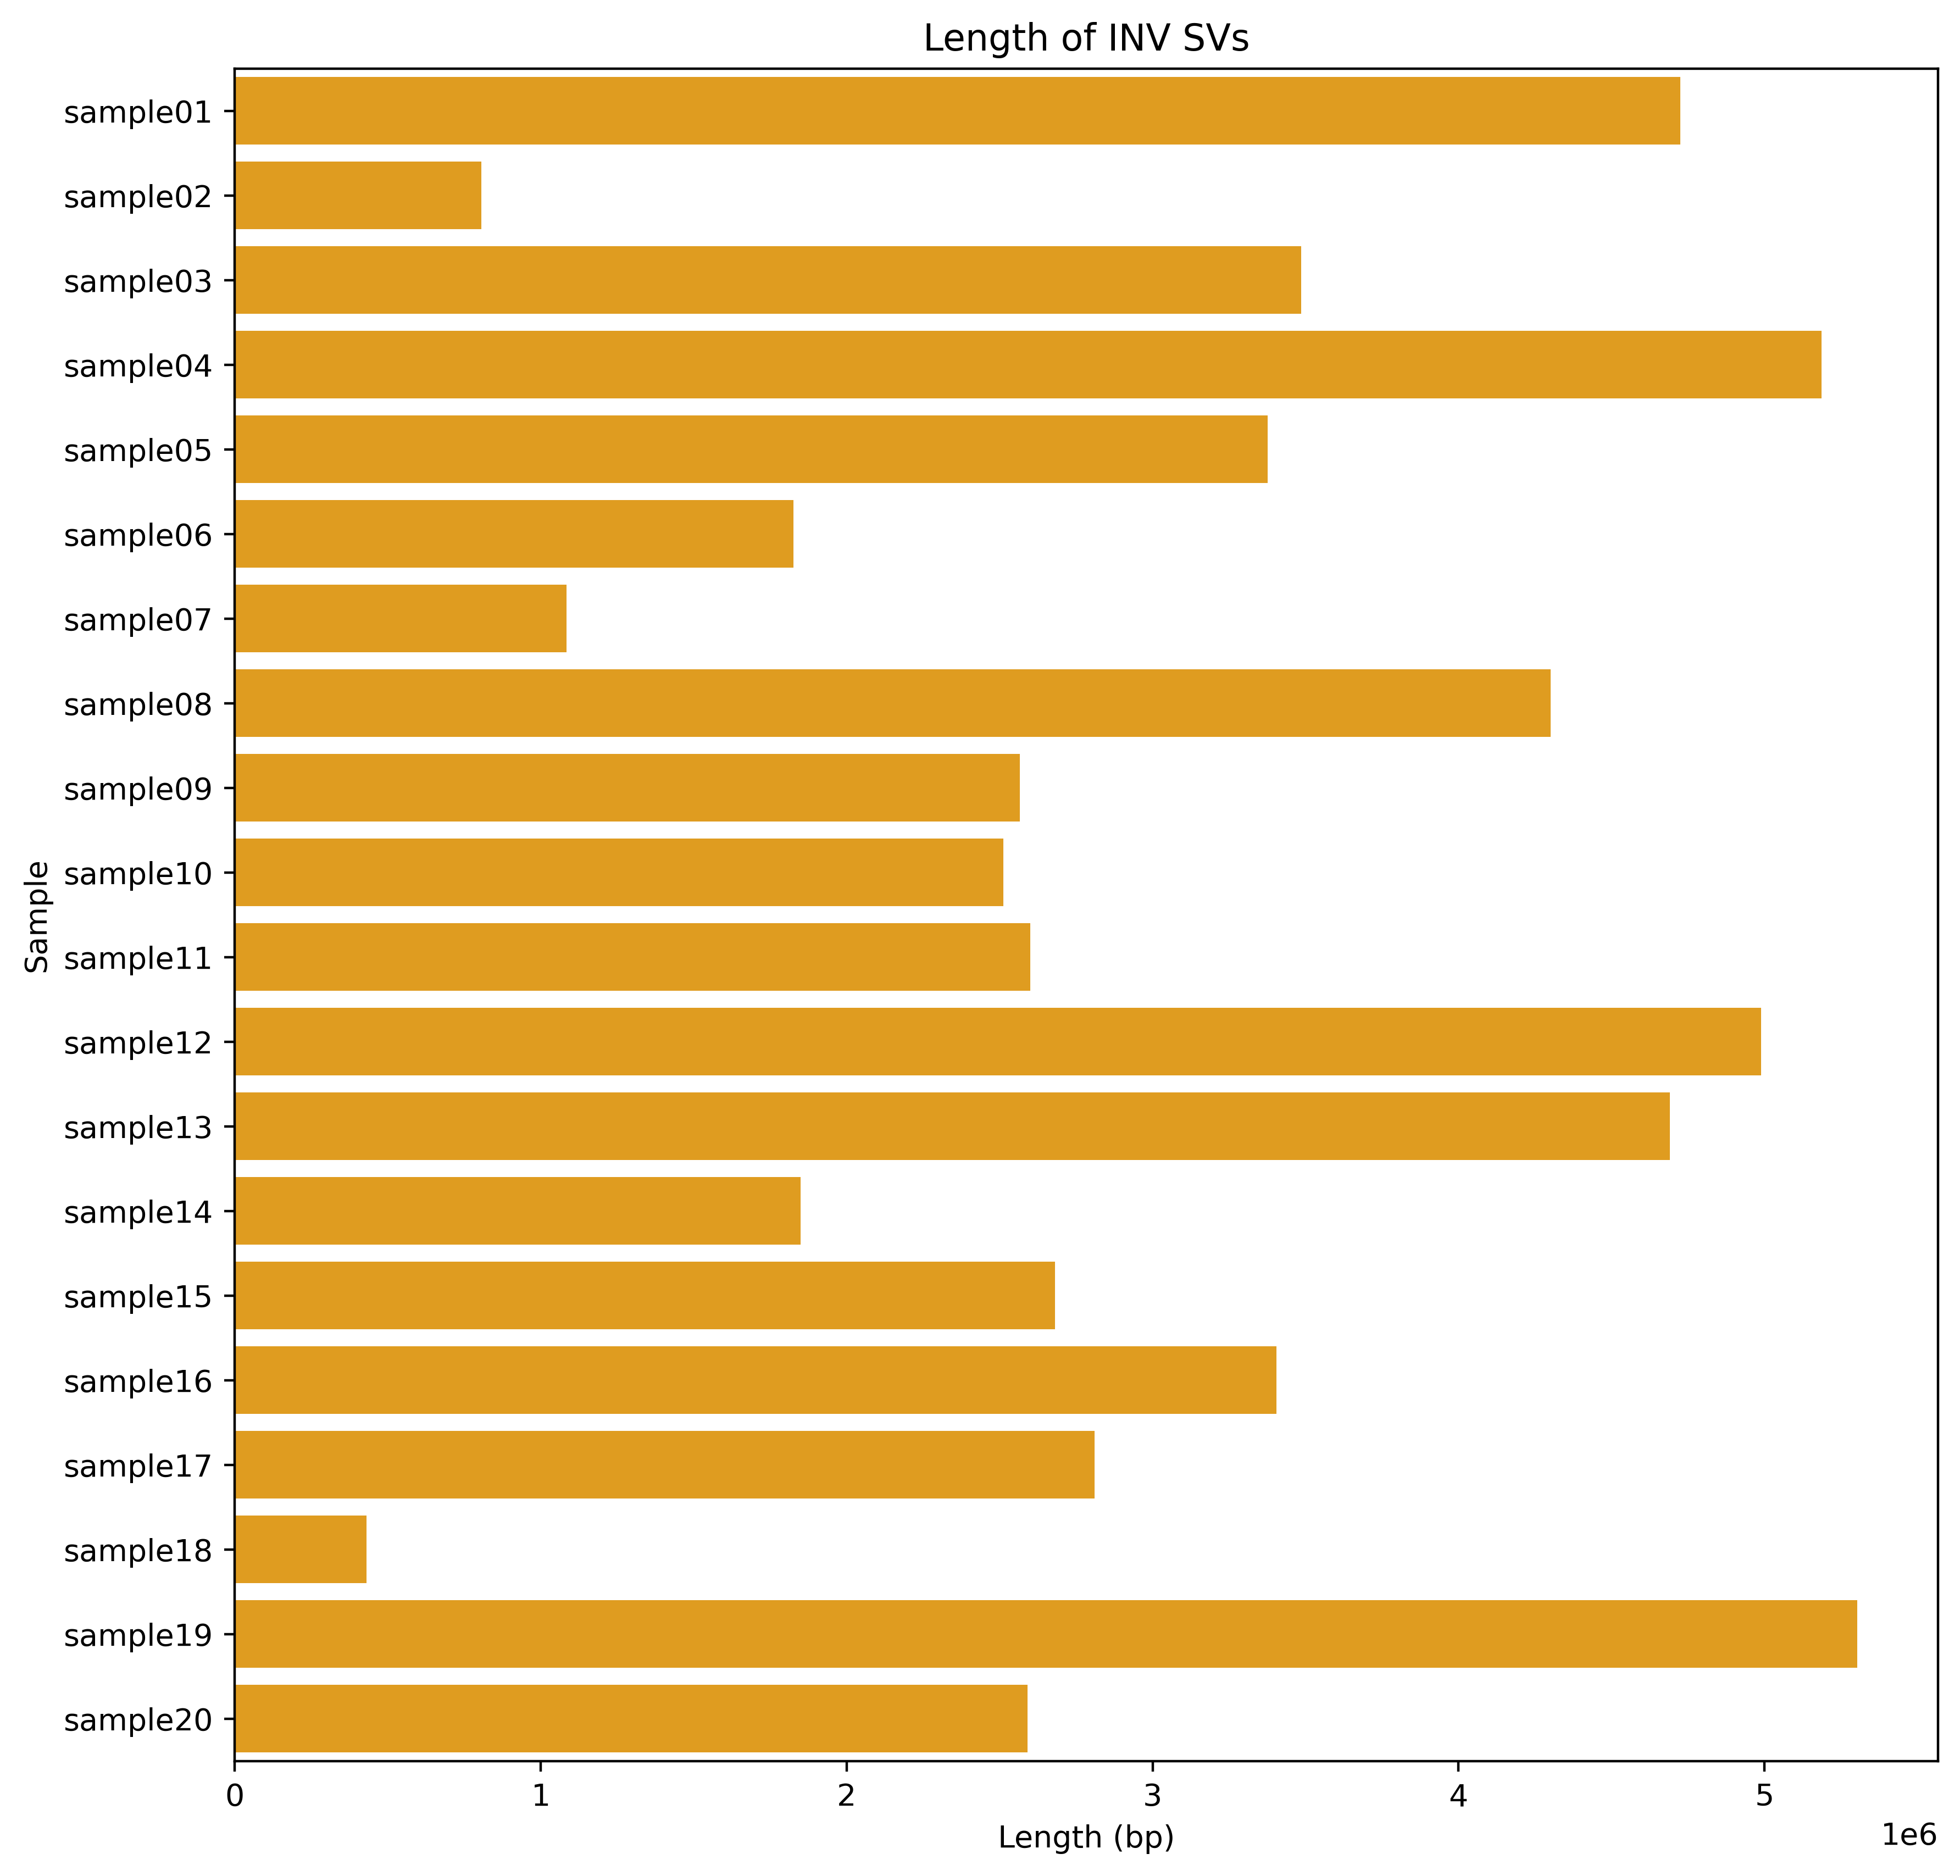

In [ ]:
# SV_TYPE = 'INV'
# plt.figure(figsize=(10,10), dpi=400)
# # sns.barplot(data=plot_df, y='sample',
# #             x='Length', hue='SV_type',
# #             col_wrap = 2, col='SV_type', kind='bar',
# #             hue_order=['DUP','INV','INS','DEL'])

# sns.barplot(data=plot_df[plot_df['SV_type'] == SV_TYPE], y = 'sample',
#             x='Length', orient='h',
#             color='orange')
# plt.xlabel('Length (bp)')
# plt.ylabel('Sample')
# plt.title(f'Length of {SV_TYPE} SVs')


/var/folders/vl/n44v99hn7v96skr346cz_cl80000gn/T/ipykernel_22132/4091826476.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1e7)


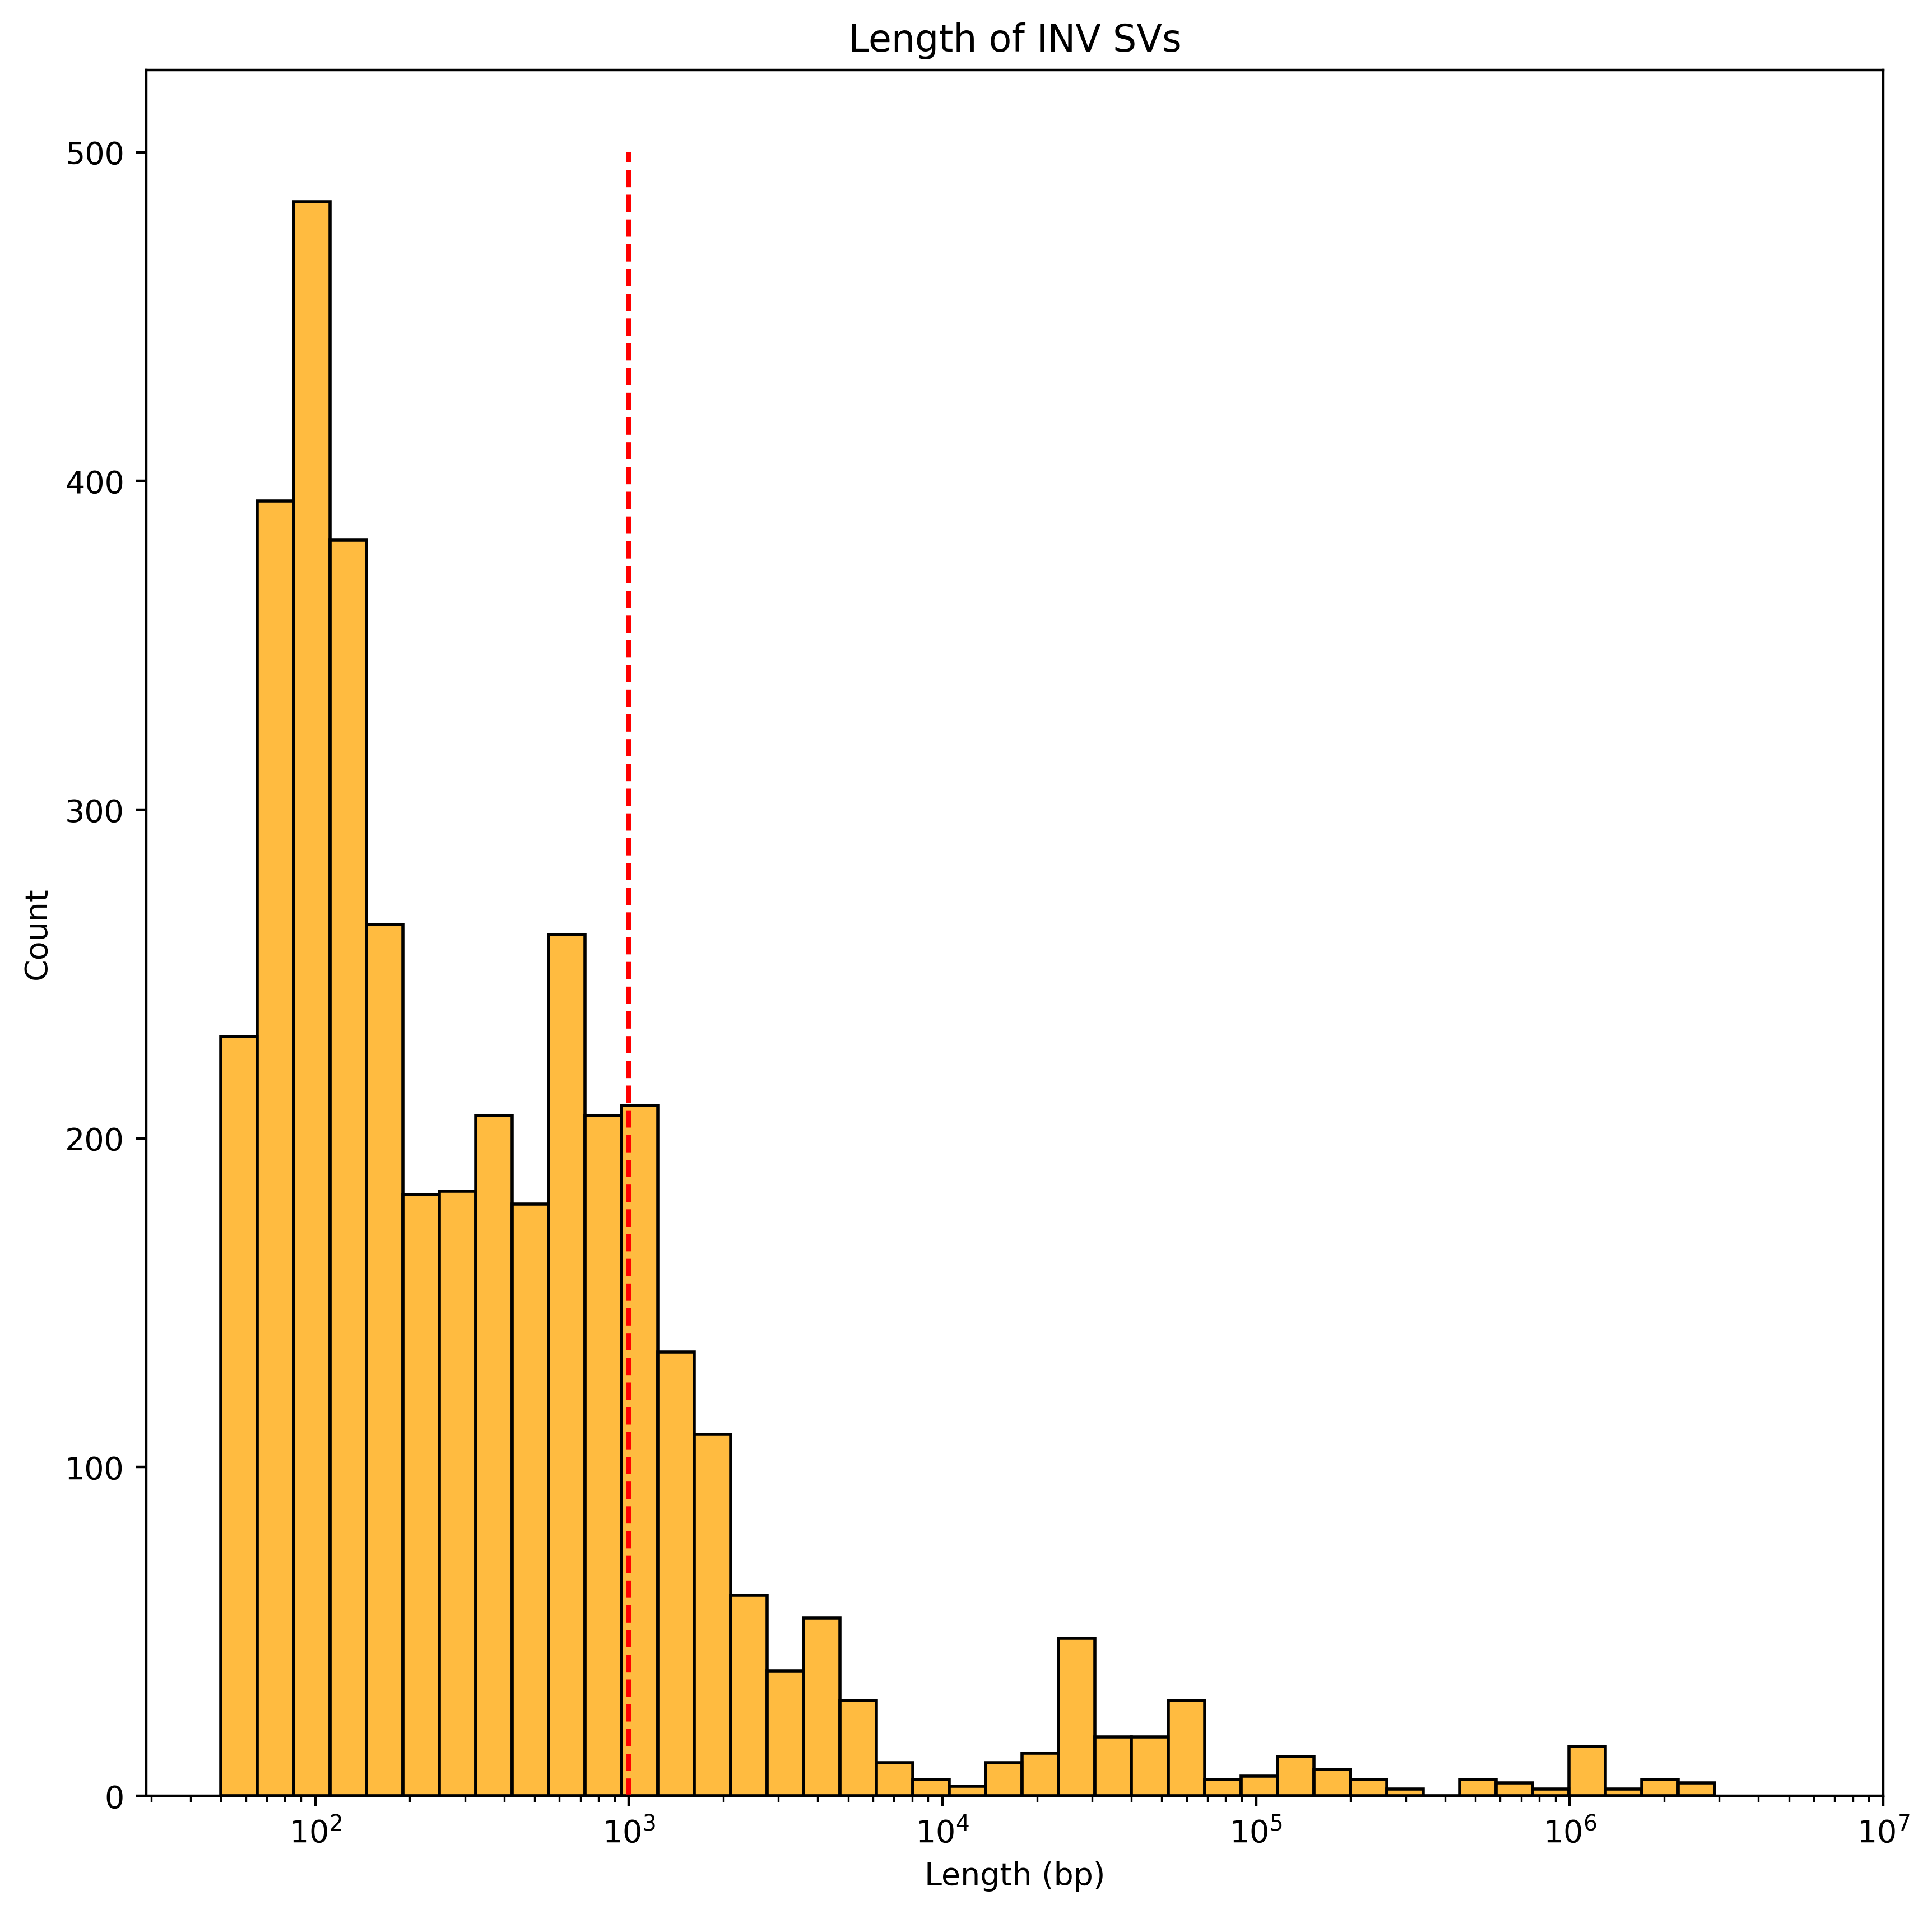

In [32]:
SV_TYPE = 'INV'
plt.figure(figsize=(10,10), dpi=400)
# sns.barplot(data=plot_df, y='sample',
#             x='Length', hue='SV_type',
#             col_wrap = 2, col='SV_type', kind='bar',
#             hue_order=['DUP','INV','INS','DEL'])

sns.histplot(data=sv_df[sv_df['sv_type'] == SV_TYPE],
            x='sv_length',log_scale=True,
            color='orange')
plt.xlabel('Length (bp)')
plt.xlim(0, 1e7)
plt.title(f'Length of {SV_TYPE} SVs')
plt.vlines(x=1e3, ymin=0, ymax=500, color='red', linestyle='--')

In [62]:
sv_df[sv_df['sv_type'] == SV_TYPE].groupby('sample').agg({'sv_type':'count'}).mean()

sv_type    192.3
dtype: float64

In [63]:
plot_df[plot_df['SV_type'] == SV_TYPE]['Length'].mean()

np.float64(3061098.15)

sv_type    10582.75
dtype: float64

In [28]:
plot_df[plot_df['SV_type'] == 'INS']

,sample,SV_type,Length
0,sample01,INS,6485628
1,sample02,INS,6426372
2,sample03,INS,6168161
3,sample04,INS,7507380
4,sample05,INS,7236057
5,sample06,INS,7590185
6,sample07,INS,8198704
7,sample08,INS,8101687
8,sample09,INS,7859077
9,sample10,INS,5854453


In [114]:
# Get stats on human SVs
human_sv = VariantFile('/Users/callummacphillamy/Downloads/gnomad.v4.1.sv.sites.vcf.gz')

svs = {'INS':[],
       'DEL':[],
       'DUP':[],
       'INV':[]}

total_svs = 0

for record in tqdm(human_sv.fetch()):
    if 'PASS' not in record.filter.keys():
        continue
    
    try:
        if record.info['N_BI_GENOS_nfe'] < 10000:
            continue
    except KeyError:
        continue

    total_svs += 1

    sv_type = record.info['SVTYPE']
    sv_len = record.info['SVLEN']

    if sv_type not in ['DEL', 'DUP', 'INV', 'INS']:
        continue
    svs[sv_type].append(sv_len)

[E::idx_find_and_load] Could not retrieve index file for '/Users/callummacphillamy/Downloads/gnomad.v4.1.sv.sites.vcf.gz'
2154486it [02:16, 15785.71it/s]


In [115]:
for k, v in svs.items():
    print(k, np.median(v))

INS 280.0
DEL 703.0
DUP 338.0
INV 7095.0


In [86]:
x = sv_df[sv_df['sv_id'].isin(svs_to_keep)]
x = sv_df.groupby(['sv_type']).agg({'sv_length':'median'}).reset_index()
x
# for sample in y['sample'].unique():
#     ins_len = y[(y['sample'] == sample) & (y['sv_type'] == 'INS')]['sv_length'].median()
#     del_len = y[(y['sample'] == sample) & (y['sv_type'] == 'DEL')]['sv_length'].median()
#     dup_len = y[(y['sample'] == sample) & (y['sv_type'] == 'DUP')]['sv_length'].median()
#     inv_len = y[(y['sample'] == sample) & (y['sv_type'] == 'INV')]['sv_length'].median()
#     all_len = ins_len + del_len + dup_len + inv_len
#     plot_dict[sample] = {'INS':ins_len, 'DEL':del_len,
#                          'DUP':dup_len, 'INV':inv_len}
#     all_plot_dict[sample] = all_len
# plot_df = pd.DataFrame.from_dict(plot_dict).T
# plot_df = plot_df.reset_index()
# plot_df

,sv_type,sv_length
0,DEL,143.0
1,DUP,4522.0
2,INS,203.0
3,INV,241.5


In [87]:
all_plot_df = all_plot_df.rename(columns={'SV affected bases':'affected bases'})
all_plot_df['Variant'] = 'SV'
all_plot_df

,sample,Length,Variant
0,sample01,25086971,SV
1,sample02,21133665,SV
2,sample03,25176803,SV
3,sample04,26835041,SV
4,sample05,25510417,SV
5,sample06,27037926,SV
6,sample07,24886171,SV
7,sample08,26785551,SV
8,sample09,27033944,SV
9,sample10,21728907,SV


In [88]:
for sample in plot_df['sample'].unique():
    total_affected_bases = plot_df[plot_df['sample'] == sample]['Length'].sum()
    print(f'{sample} has {total_affected_bases} bases affected by large INS/DELs')

sample01 has 25086971 bases affected by large INS/DELs
sample02 has 21133665 bases affected by large INS/DELs
sample03 has 25176803 bases affected by large INS/DELs
sample04 has 26835041 bases affected by large INS/DELs
sample05 has 25510417 bases affected by large INS/DELs
sample06 has 27037926 bases affected by large INS/DELs
sample07 has 24886171 bases affected by large INS/DELs
sample08 has 26785551 bases affected by large INS/DELs
sample09 has 27033944 bases affected by large INS/DELs
sample10 has 21728907 bases affected by large INS/DELs
sample11 has 26389006 bases affected by large INS/DELs
sample12 has 23010472 bases affected by large INS/DELs
sample13 has 26522052 bases affected by large INS/DELs
sample14 has 29940918 bases affected by large INS/DELs
sample15 has 24377997 bases affected by large INS/DELs
sample16 has 27837603 bases affected by large INS/DELs
sample17 has 27434856 bases affected by large INS/DELs
sample18 has 24849692 bases affected by large INS/DELs
sample19 h

In [89]:
all_plot_df

,sample,Length,Variant
0,sample01,25086971,SV
1,sample02,21133665,SV
2,sample03,25176803,SV
3,sample04,26835041,SV
4,sample05,25510417,SV
5,sample06,27037926,SV
6,sample07,24886171,SV
7,sample08,26785551,SV
8,sample09,27033944,SV
9,sample10,21728907,SV


In [90]:
# Get the number of SNPs
VCFS = glob.glob('/Users/callummacphillamy/Projects/tuwa_manuscript/TuWa_manuscript/SNP_analyses/genotypes/SNPs/*.vcf.gz')

bases_affected_by_snps = {}

for vcf in tqdm(VCFS):
    sample_name = os.path.basename(vcf).split('.')[0]
    if bases_affected_by_snps.get(sample_name) is None:
        bases_affected_by_snps[sample_name] = 0
    v_file = VariantFile(vcf)
    for record in v_file.fetch():
        #print(record)
        if 'PASS' not in record.filter.keys():
            continue
        if record.qual < 20:
            continue
        alleles = record.alleles
        ref = record.ref
        
        for allele in alleles:
            if len(allele) > 1:
                continue

        gt = record.samples[sample_name]['GT']
        if gt in [(None,None), (0,0)]:
            continue

        allele_1 = len(alleles[gt[0]])
        allele_2 = len(alleles[gt[1]])

        if allele_1 > allele_2:
            bases_affected_by_snps[sample_name] += allele_1
        else:
            bases_affected_by_snps[sample_name] += allele_2


100%|██████████| 620/620 [09:41<00:00,  1.07it/s]


<Axes: xlabel='affected bases', ylabel='sample'>

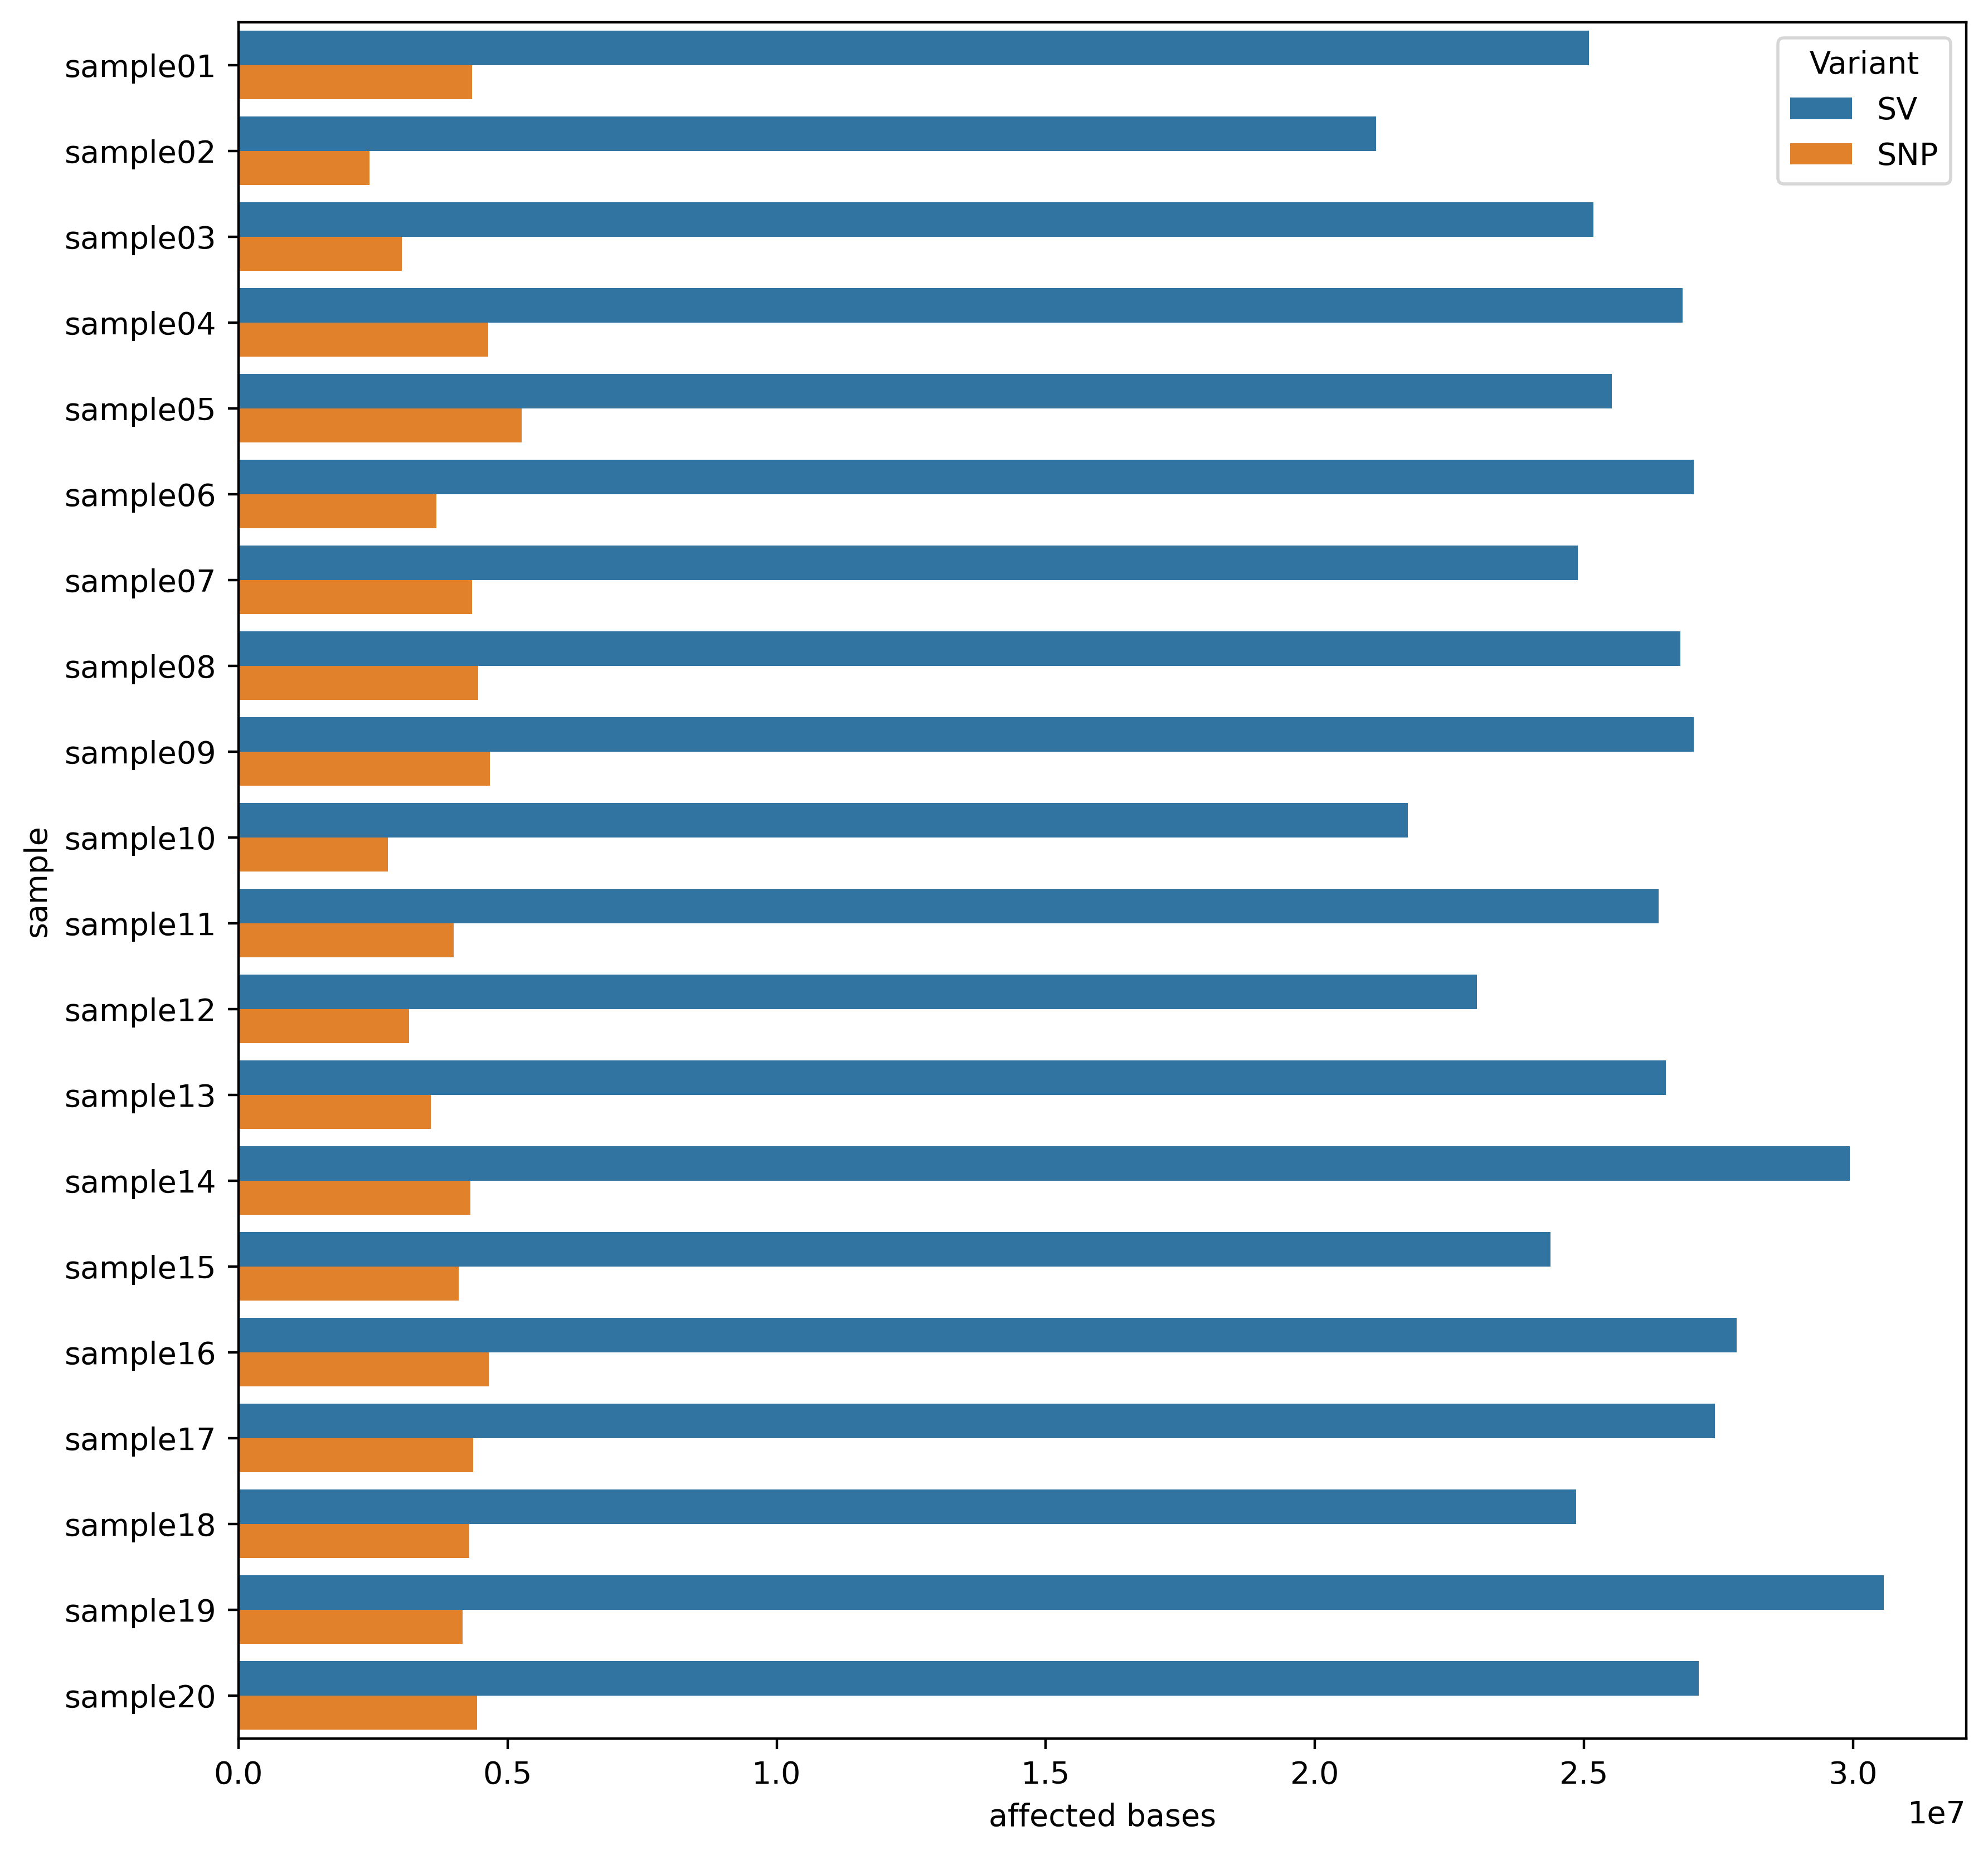

In [98]:
plt.figure(figsize=(10,10), dpi=400)
snps = pd.DataFrame.from_dict(bases_affected_by_snps, orient='index', columns=['affected bases']).reset_index()
snps.columns = ['sample','affected bases']

snps['Variant'] = 'SNP'
all_plot_df = all_plot_df.rename(columns={'Length':'affected bases'})
snp_vs_sv_df = pd.concat([all_plot_df, snps])
snp_vs_sv_df
sns.barplot(data=snp_vs_sv_df, y='sample', x='affected bases', hue='Variant')

In [92]:
allele_1

1

In [93]:
sv_df['length_bins'] = pd.cut(sv_df['sv_length'], bins=[0, 1000, 10000, 100000, 1000000, 10000000, 100000000], labels=['0-1kb','1-10kb','10-100kb','100kb-1Mb','1Mb-10Mb','10Mb-100Mb'])

<Axes: xlabel='length_bins', ylabel='Count'>

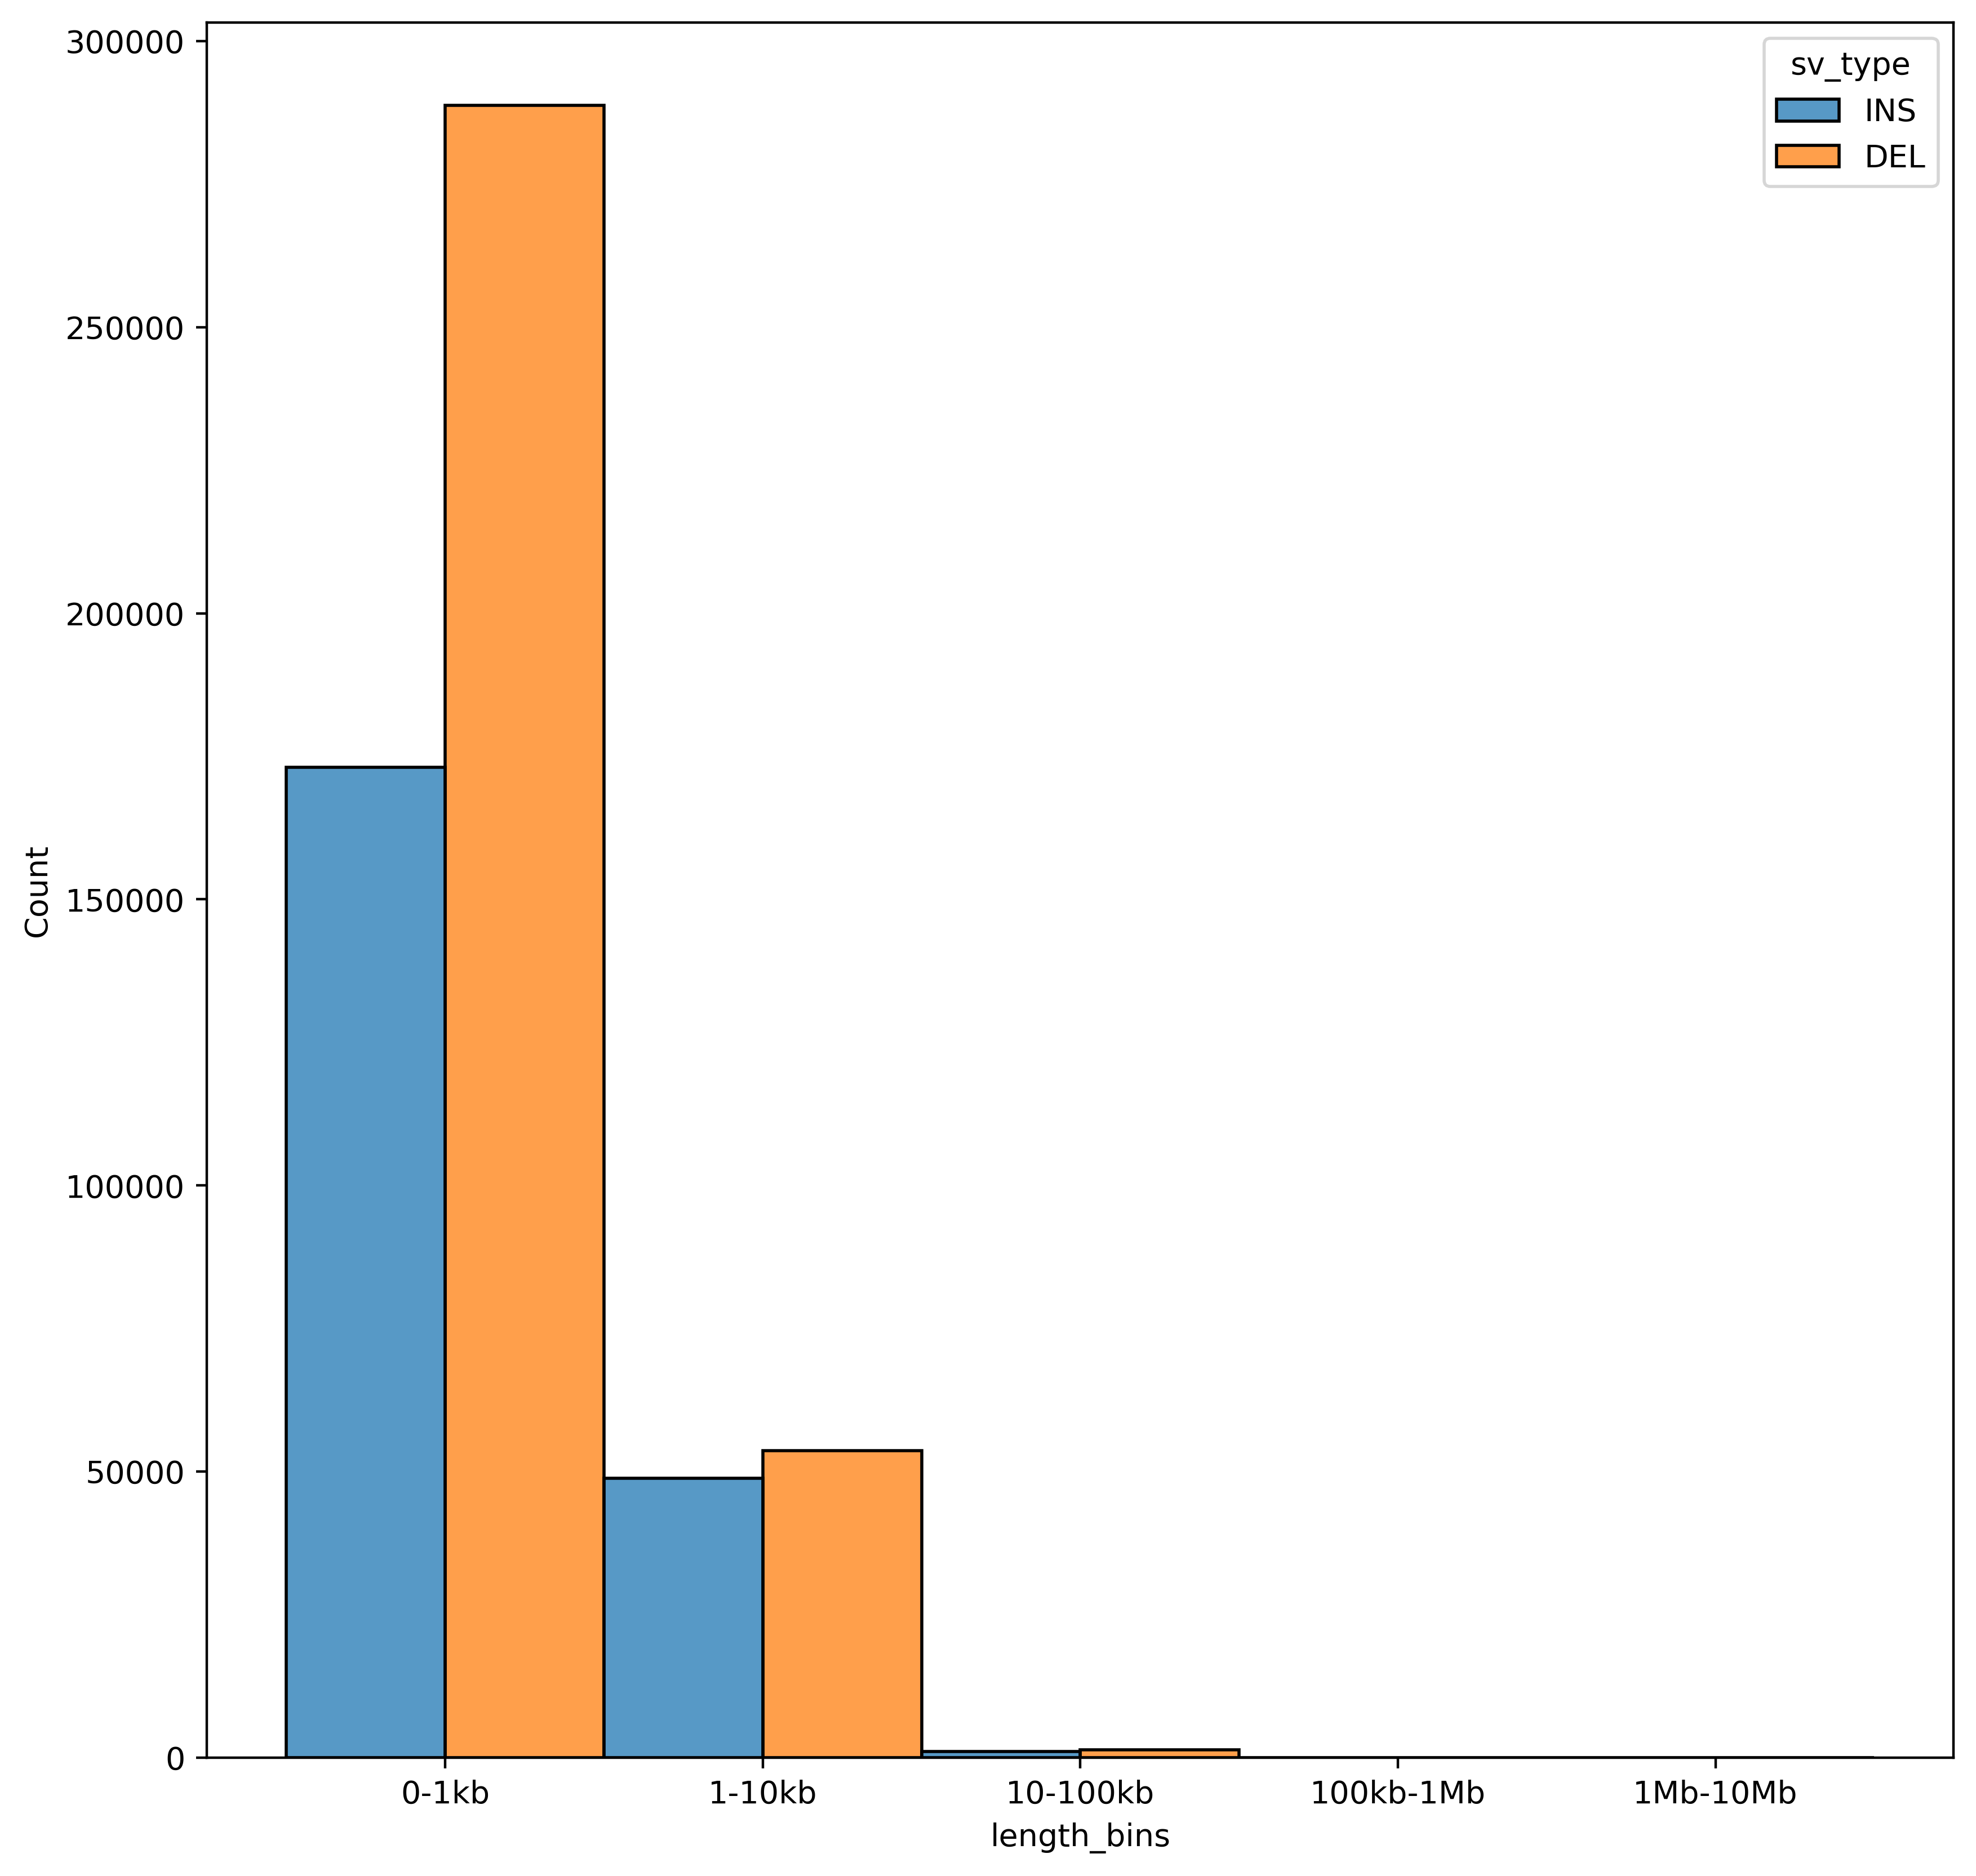

In [94]:
plt.figure(figsize=(10,10), dpi=400)
sns.histplot(data=sv_df[sv_df['sv_type'].isin(['INS','DEL'])],
             x='length_bins', hue='sv_type', multiple='dodge')

In [95]:
53166 / 5838967

0.009105377714928

In [40]:
# Merge SVs
samples = ['sample11','sample05','sample04','sample10','sample06','sample12',
           'sample13','sample07','sample03','sample17','sample16','sample02',
           'sample14','sample01','sample15','sample18','sample19','sample09',
           'sample08','sample20']
SNIFFLES_MERGE ='../../../tuwa_manuscript/TuWa_manuscript/RESULTS/mapped_to_wagyu/SVs/sniffles/snfs/wagyu.cohort.vcf'

sniffles_merge = VariantFile(SNIFFLES_MERGE)

atleast_2 = []

for record in sniffles_merge.fetch():
    #print(record)
    #print(record.info['SUPP_VEC'])
    if record.info['SUPP_VEC'].count('1') >= 2:
        atleast_2.append(record)
print(len(atleast_2))

48317


In [42]:
print(atleast_2[0])

1	1042373	Sniffles2.DEL.1M4	N	<DEL>	30	PASS	IMPRECISE;SVTYPE=DEL;SVLEN=-1402;END=1043774;SUPPORT=3;COVERAGE=4,4,4,4,4;STRAND=+-;AC=2;STDEV_LEN=2.121;STDEV_POS=88.388;SUPP_VEC=00000000010000100000	GT:GQ:DR:DV:ID	./.:0:0:0:NULL	./.:0:2:0:NULL	./.:0:1:0:NULL	./.:0:0:0:NULL	./.:0:0:0:NULL	./.:0:1:0:NULL	./.:0:2:0:NULL	./.:0:2:0:NULL	./.:0:0:0:NULL	0/1:11:2:3:Sniffles2.DEL.77BS0	./.:0:1:0:NULL	./.:0:0:0:NULL	./.:0:0:0:NULL	./.:0:0:0:NULL	0/1:1:1:3:Sniffles2.DEL.731S0	./.:0:0:0:NULL	./.:0:3:0:NULL	./.:0:0:0:NULL	./.:0:2:0:NULL	./.:0:0:0:NULL

